In [52]:
from IPython.display import HTML

In [98]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Visualizing Linear Regression:

Contributors: Matt Winkler and Drew Malter  
July 2018

### Goal:

This analysis explores visualizations of linear regression to provide a more practical & intuitive understanding of what they mean and how they work.

### Data:

The data used for this analysis originally came from a Kaggle competition sponsored by Allstate. https://www.kaggle.com/c/allstate-purchase-prediction-challenge/data. In this analysis, we focus on predicting the quoted policy cost based on the rest of the data.

### Background:

Regressions are a supervised learning method used for predicting continuous numeric variables. Linear regressions answer _how much_ a target varible is impacted by one or several predictor variables. For example: _How much_ does the cost of car insurance change based on location, age, car age, etc?  To do this, they essentially solve for m in the familiar y = mx + b.

#### In summary:

* Supervised learning with continuous variable
* _How much?_
* think y = mx + b

![title](images/linearRegression.png)

### Why is visualizing regressions worth it?

##### They're important!

Regressions are the most common way for assessing whether  

* there's a relationship between two things and  
* how strong the relationship is.  

While they're one of the oldest forms of machine learning, they're still highly relevant in economics, healthcare, and insurance among other domains. 

##### The way people typically display regression results isn't very helpful :(

While regression output tables are useful interpretation tools for experienced statisticians, they're awful from a visualization standpoint. When interpreting a regression, there are several things people want to know:

* Which predictor variables have significant effects on the target variable?  
* How strong are those effects?  
* How accurately can we predict the target variable?

In [54]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from ipywidgets import interact, interact_manual, widgets, Layout

from bokeh.io import push_notebook, show, output_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models.annotations import Title
from bokeh.models.widgets import MultiSelect
from bokeh.models import Button
from bokeh.layouts import widgetbox, column, row

from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline
warnings.filterwarnings('ignore')

In [55]:
# load dataset:
df = pd.read_csv('data/CarInsurance_Claims.csv')

# preview of the data:
df.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,8:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,8:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,8:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630


In [56]:
# number of observations x number of features:
#df.shape

In [57]:
# datatypes for each column:
#df.dtypes

We are going to drop the A-G columns for this exercise, since they're categorical dependent variables which don't have a relationship with the rest of the predictor variables or the cost.  We'll also remove customer_ID to avoid accidentally fitting the predictions to individual customers.

In [58]:
df.drop(columns=['customer_ID'], 
        axis = 1, 
       inplace=True)

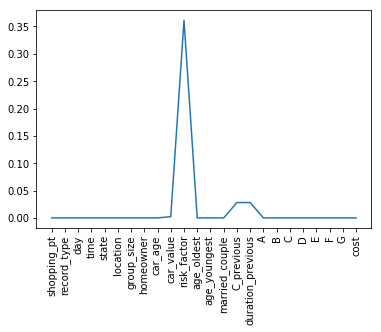

In [59]:
# percentage of missing values by column:
nulls = df.isnull().sum() / df.shape[0]
labels = nulls.index
_ = plt.plot(nulls)
_ = plt.xticks(rotation='vertical')

There are a relatively high number of nulls in the risk_factor column at over 35%. C_previous and duration_previous are also missing some values.  We could fill in the missing values with a number of methods (mean, median, separate classification / regression models).  We are fortunate to have a lot of data in this set, so will drop the records with missing values.

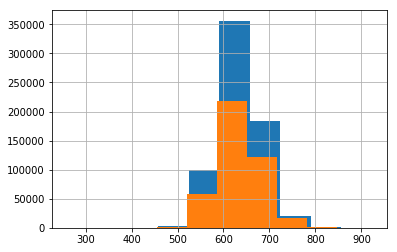

In [60]:
df2 = df.dropna()

# check shape of distributions with and without NAs
df['cost'].hist()
df2['cost'].hist()

In [61]:
#df.describe()

In [62]:
#df2.describe()

There are a couple of things to note from the output above. One, we didn't change the variable distributions too much by removing records with missing values. If we had, we'd risk affecting the coefficient estimates produced by the regression.

By comparing the mean and median values, we can also see that several variables have skewed distributions, since the mean and median are far apart.  There are a couple remaining steps for our data prep: 

1) The above only looks at the numeric features in the data. We should also look at the categoricals to determine whether they have any potential value.

2) Regression is sensitive to outliers in the data, so we want to evaluate and address variable skew before proceeding further.


In [63]:
df = df2
del df2

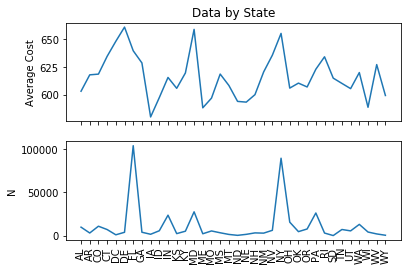

In [64]:
state_cost = df.groupby('state')['cost'].mean()
state_count = df.groupby('state').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(state_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by State')
_ = ax2.plot(state_count)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There are some states with many more observations than others. Average cost also varies by up to 10% depending on the state. It may be interesting to see if geographic influence is detectable in the regression, so we'll keep the state variable for the moment.

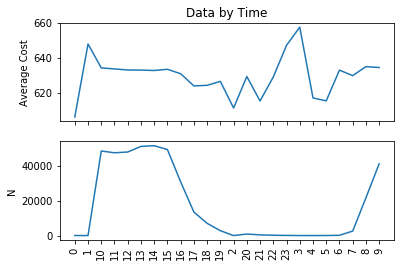

In [65]:
# get the times as a list and round to the hour:
times = df['time'].values.tolist()
df['time'] = [tm.split(':')[0] for tm in times]

time_cost = df.groupby('time')['cost'].mean()
time_count = df.groupby('time').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(time_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by Time')
_ = ax2.plot(time_count)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There isn't much variation of the cost across different values of the time variable. So, let's drop this feature.  The one exception is the spike in average cost paid early in the morning (4-5 AM).  This occurs at a low volume point, however, so it's unlikely to help our model much.

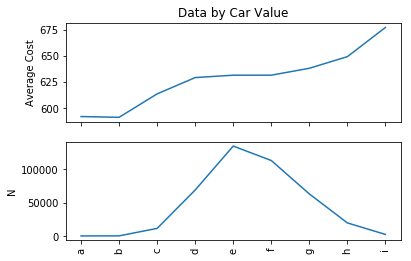

In [66]:
car_cost = df.groupby('car_value')['cost'].mean()
car_counts = df.groupby('car_value').size()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
_ = ax1.plot(car_cost)
_ = ax1.set_ylabel('Average Cost')
_ = ax1.set_title('Data by Car Value')
_ = ax2.plot(car_counts)
_ = ax2.set_ylabel('N')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

There appears to be a relationship between the car_value feature and the cost. However, there are relatively few observations at the high and low ends of car_value. We can try bucketing values a-c and g-i together.

In [67]:
df.loc[df['car_value'].isin(['a', 'b', 'c']), 'car_value'] = 'a-c'
df.loc[df['car_value'].isin(['g', 'h', 'i']), 'car_value'] = 'g-i'

In [68]:
# remove the time variable as discussed earlier:
df.drop(columns=['time'], axis=1, inplace=True)

In [69]:
# clean up duration_previous, C_previous, and risk_factor columns since they should be ints
df['duration_previous'] = df['duration_previous'].astype(int)
df['C_previous'] = df['C_previous'].astype(int)
df['risk_factor'] = df['risk_factor'].astype(int)

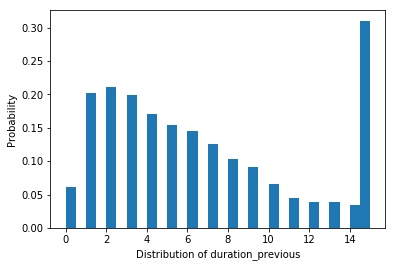

In [70]:
# Example plotting a single variable to evaluate its skew:
feature = 'duration_previous'
plt.hist(df[feature], density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Distribution of {}'.format(feature));

What if we had a dataset with 1,000 (or 10,000) variables and wanted to evaluate the skew for each? We'd need a lot of code! Or, we can use a more interactive approach to look at each variable in turn with the Bokeh library.

In [71]:
# plot setup:
p = figure(title="Test", 
           background_fill_color="#E8DDCB", 
           width=500, 
           height=300)

# get values and make histogram:
arr = df['car_age'].values
hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=50)

# assign histogram to the figure:
r = p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

show(p)

# update() function to make the plot interactive:
def update(feature, num_bins):
    # update array and histogram values:
    arr = df[feature].values
    hist, edges = np.histogram(arr, 
                           density=True, 
                           bins=num_bins)
    
    # update plot parameters:
    p.title.text = 'Probability distribution of {}'.format(feature)
    p.xaxis.axis_label = '{}'.format(feature)
    p.yaxis.axis_label = 'Pr({})'.format(feature)
    
    # reset the renderer data:
    r.data_source.data['top'] = hist
    r.data_source.data['left'] = edges[:-1]
    r.data_source.data['right'] = edges[1:]
    
    push_notebook()

output_notebook()

Loading BokehJS ...

In [72]:
features = [f for f in df.columns.values if f not in \
            ['car_value', 'state', 'location']]
nbins = (5, 50)
interact(update, feature = features, num_bins = nbins)
show(p, notebook_handle = True)

interactive(children=(Dropdown(description='feature', options=('shopping_pt', 'record_type', 'day', 'group_siz…

Now let's look at the boxplots for each feature in the data to check them all for outliers

In [73]:
def min_max(col):
    """Min-max scales input to 0-1 range."""
    mn = min(col)
    mx = max(col)
    scaled = ((col - mn) / (mx - mn))
    return scaled

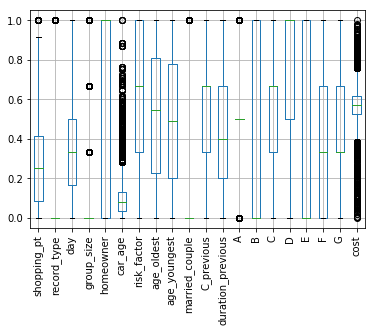

In [74]:
scaled = df[features].apply(min_max)
my_plt = scaled.boxplot(rot=90)

Based on the above, car_age could be capped based on its high skew. Check first whether there is a clear relationship between the two.

In [75]:
# TODO make this a scatter plot across all the variables in the dataset
#_ = df.plot.scatter('cost', 'car_age')

In [76]:
# define outlier adjustment function:
def adjust_outliers(array_in):
    """ Finds and replaces outliers in input array with 1.5 * IQR"""
    array_out = np.array(array_in)
    
    q1 = array_in.quantile(q=0.25)
    q3 = array_in.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    below_ind = array_out < lower
    above_ind = array_out > upper
    
    array_out[below_ind] = lower
    array_out[above_ind] = upper
    
    changed = np.sum(array_in != array_out)
    print('Found and adjusted {} values in {} column'.format(str(changed), array_in.name))
    return array_out

In [77]:
# adjust outliers in the car_age_feature:
df['car_age'] = adjust_outliers(df['car_age'])

Found and adjusted 4896 values in car_age column


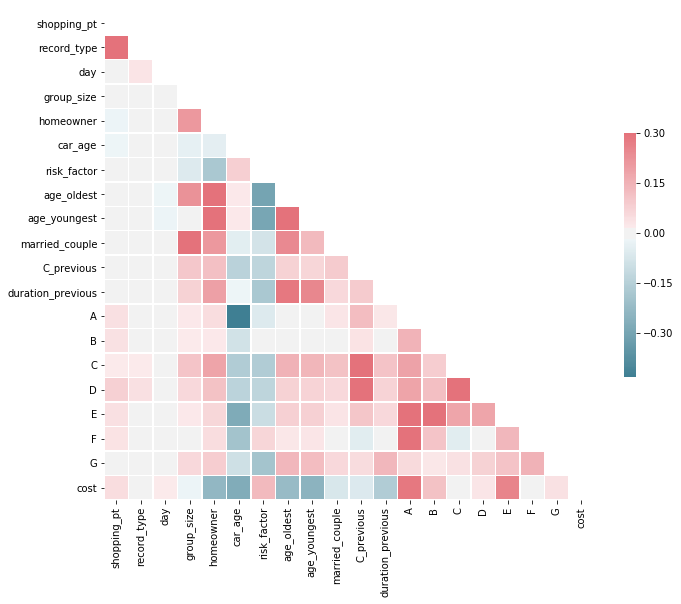

In [78]:
corr = df[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Overall there don't appear to be strong correlations in the dataset across the intput variables or with the target. age_oldest and age_youngest are an exception, with a correlation of over .9. We should encode some of the features as binary variables since their values don't necessarily represent incremental increases

In [79]:
#df.nunique()

In [80]:
# one-hot encoding of categorical columns:
df = pd.get_dummies(df,
                    drop_first=True,
                    columns = ['state', 'group_size', 
                               'risk_factor', 'car_value', 'C_previous', 
                               'A', 'B', 'C', 'D', 'E', 'F', 'G'])

In [81]:
# Days 5 and 6 are weekend days, add a flag for them vs. the others
df['weekend'] = df['day'].isin([5, 6]).astype(int)

In [82]:
y = df['cost']
X = df.drop(columns=['cost', 'location', 'shopping_pt', 'age_youngest', 'day'])

In [83]:
lm = linear_model.LinearRegression()

#Split data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#Fit the model :
lm.fit(X_train, y_train)

#Set predictions
lm_train_pred = lm.predict(X_train)
lm_test_pred = lm.predict(X_test)

In [84]:
y_mn_train = np.mean(y_train)
sst_train = sum((y_train - y_mn_train)**2)
ssr_train = sum((lm_train_pred - y_train)**2)
r2_train = 1 - (ssr_train / sst_train)

y_mn_test = np.mean(y_test)
sst_test = sum((y_test - y_mn_test)**2)
ssr_test = sum((lm_test_pred - y_test)**2)
r2_test = 1 - (ssr_test / sst_test)

print('R^2 of the model on training data was: {}'.format(str(r2_train)))
print('R^2 of the model on testing data was: {}'.format(str(r2_test)))

R^2 of the model on training data was: 0.4785137536998014
R^2 of the model on testing data was: 0.4808732515304228


In [85]:
#Return the summary of the model
#X2 = sm.add_constant(X)
#est = sm.OLS(y, X2)
#est2 = est.fit()
#print(est2.summary())

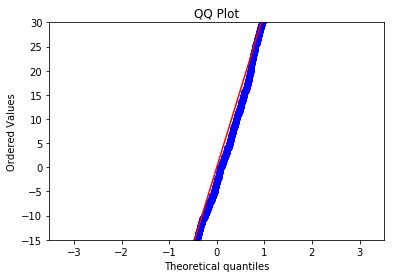

In [86]:
# Check residual distribution:
import pylab 
import scipy.stats as stats

idx = np.random.choice(X_train.index, 1000, replace=False)

x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

#Set predictions
lm.fit(x_train_sample, y_train_sample)
lm_train_pred_sample = lm.predict(x_train_sample)

residuals = y_train_sample - lm_train_pred_sample
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.ylim([-15,30])
pylab.title("QQ Plot")
pylab.show()

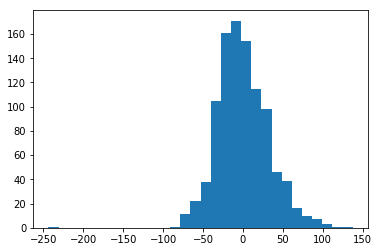

In [87]:
_ = plt.hist(residuals, bins=30)

The regression residuals don't deviate from a normal distribution, which means there is not systemic bias in the model's predictions.  

### Now check for interaction terms for potential to improve fit:

"Interaction terms" are useful when the target variable depends on _combinations_ of predictor variables. Marriage status and family size from this dataset are a great example.

In [88]:
"""
interactions = list()
baseline = r2_train

checks = ['homeowner', 'married_couple', 'C_previous_2', 'C_previous_3', 'C_previous_4',
          'duration_previous', 'age_oldest', 'car_age', 'risk_factor_2', 'risk_factor_3', 'risk_factor_4', 
         'car_value_d', 'car_value_e', 'car_value_f', 'car_value_g-i', 
         'group_size_2', 'group_size_3', 'group_size_4', 'A_1', 'A_2', 'B_1', 
         'C_2', 'C_3', 'C_4', 'D_2', 'D_3', 'E_1', 'F_1', 'F_2', 'F_3', 'G_2', 'G_3', 'G_4']

for feature_A in checks:
    for feature_B in checks:
        
        if feature_A > feature_B:
            X_train['interaction'] = X_train[feature_A] * X_train[feature_B]
            
            lm.fit(X_train, y_train)
            lm_train_pred = lm.predict(X_train)
                
            y_mn_train = np.mean(y_train)
            sst_train = sum((y_train - y_mn_train)**2)
            ssr_train = sum((lm_train_pred - y_train)**2)
            r2_train = 1 - (ssr_train / sst_train)
            
            improvement = r2_train - baseline
            
            if r2_train > baseline:
                interactions.append((feature_A, feature_B, round(improvement,3)))

print('Baseline R2: %.3f' % r2_train)
print('Top 20 interactions: %s' % sorted(interactions, key=lambda x: x[2],
 reverse=True)[:20])
"""

"\ninteractions = list()\nbaseline = r2_train\n\nchecks = ['homeowner', 'married_couple', 'C_previous_2', 'C_previous_3', 'C_previous_4',\n          'duration_previous', 'age_oldest', 'car_age', 'risk_factor_2', 'risk_factor_3', 'risk_factor_4', \n         'car_value_d', 'car_value_e', 'car_value_f', 'car_value_g-i', \n         'group_size_2', 'group_size_3', 'group_size_4', 'A_1', 'A_2', 'B_1', \n         'C_2', 'C_3', 'C_4', 'D_2', 'D_3', 'E_1', 'F_1', 'F_2', 'F_3', 'G_2', 'G_3', 'G_4']\n\nfor feature_A in checks:\n    for feature_B in checks:\n        \n        if feature_A > feature_B:\n            X_train['interaction'] = X_train[feature_A] * X_train[feature_B]\n            \n            lm.fit(X_train, y_train)\n            lm_train_pred = lm.predict(X_train)\n                \n            y_mn_train = np.mean(y_train)\n            sst_train = sum((y_train - y_mn_train)**2)\n            ssr_train = sum((lm_train_pred - y_train)**2)\n            r2_train = 1 - (ssr_train / sst_tra

We see that married_couple * group_size_2 appears to improve the fit, suggesting that married couples _without_ kids are priced differently from the rest of the sample.

In [89]:
# add top interaction terms from the previous step:
X['married_g2'] = X['married_couple'] * X['group_size_2']
X['duration_age_oldest'] = X['duration_previous'] * X['age_oldest']
X['risk_factor_3_age_oldest'] = X['risk_factor_3'] * X['age_oldest']
X['homeowner_age_oldest'] = X['homeowner'] * X['age_oldest']

In [90]:
# refit model with additional terms:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Fit the model :
lm.fit(X_train, y_train)

#Set predictions
lm_train_pred = lm.predict(X_train)
lm_test_pred = lm.predict(X_test)

In [91]:
# Check the fit:
y_mn_train = np.mean(y_train)
sst_train = sum((y_train - y_mn_train)**2)
ssr_train = sum((lm_train_pred - y_train)**2)
r2_train = 1 - (ssr_train / sst_train)

y_mn_test = np.mean(y_test)
sst_test = sum((y_test - y_mn_test)**2)
ssr_test = sum((lm_test_pred - y_test)**2)
r2_test = 1 - (ssr_test / sst_test)

print('R^2 of the model on training data was: {}'.format(str(r2_train)))
print('R^2 of the model on testing data was: {}'.format(str(r2_test)))

R^2 of the model on training data was: 0.5024837500785246
R^2 of the model on testing data was: 0.5054581442012307


Including interactions improved the model's fit by about 5%, which is nice! We're still a ways from being able to predict cost with a high degree of accuracy.

## Analyzing regression output:

There was some effort involved in producing the regression model that we're going to inspect, but we aren't going to worry about those specifics. Instead, let's look at some diagnostic output below. A few items to remember for later:

* Coefficient estimate
* Confidence interval
* R-squared

In [92]:
#Return the summary of the model
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     5711.
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:26:46   Log-Likelihood:            -2.0466e+06
No. Observations:              417447   AIC:                         4.093e+06
Df Residuals:                  417372   BIC:                         4.094e+06
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      591.7117      0.622    951.690      0.000     590.493     592.930
record_type                 -0.6518      0.142     -4.591      0.000      -0.930      -0.374
homeowner                  -27.0537      0.319    -84.741      0.000     -27.679     -26.428
car_age                     -0.8742      0.012    -75.925      0.000      -0.897      -0.852
age_oldest                  -0.4985      0.007    -74.986      0.000      -0.512      -0.485
married_couple               7.3138      0.290     25.220      0.000       6.745       7.882
duration_previous           -3.1395      0.037    -84.296      0.000      -3.213      -3.067
state_AR                    14.9337      0.669     22.332      0.000      13.623      16.244
state_CO                    11.4986      0.457     25.185      0.000      10.604      12.393
state_CT                    38.8889      0.550     70.685      0.000      37.811      39.967
state_DC                    37.4347      1.048     35.724      0.000      35.381      39.489
state_DE                    57.2320      0.617     92.686      0.000      56.022      58.442
state_FL                    44.4298      0.368    120.720      0.000      43.708      45.151
state_GA                    22.2549      0.612     36.348      0.000      21.055      23.455
state_IA                   -27.2313      0.860    -31.669      0.000     -28.917     -25.546
state_ID                    -0.5266      0.545     -0.966      0.334      -1.595       0.542
state_IN                    10.0295      0.398     25.189      0.000       9.249      10.810
state_KS                    -0.7002      0.739     -0.947      0.343      -2.149       0.748
state_KY                    17.6658      0.562     31.440      0.000      16.565      18.767
state_MD                    50.0364      0.388    128.892      0.000      49.276      50.797
state_ME                   -16.1660      0.764    -21.173      0.000     -17.663     -14.670
state_MO                   -12.5096      0.551    -22.711      0.000     -13.589     -11.430
state_MS                    15.5781      0.651     23.943      0.000      14.303      16.853
state_MT                     7.6201      0.902      8.449      0.000       5.852       9.388
state_ND                    -6.0719      1.565     -3.881      0.000      -9.138      -3.005
state_NE                    -5.9857      0.880     -6.802      0.000      -7.710      -4.261
state_NH                    -6.6713      0.664    -10.052      0.000      -7.972      -5.371
state_NM                    18.5170      0.682     27.160      0.000      17.181      19.853
state_NV                    27.8695      0.534     52.226      0.000      26.824      28.915
state_NY                    67.3682      0.405    166.415      0.000      66.575      68.162
state_OH      

![title](images/confused-emoji.png)

## Visualize the coefficients instead:

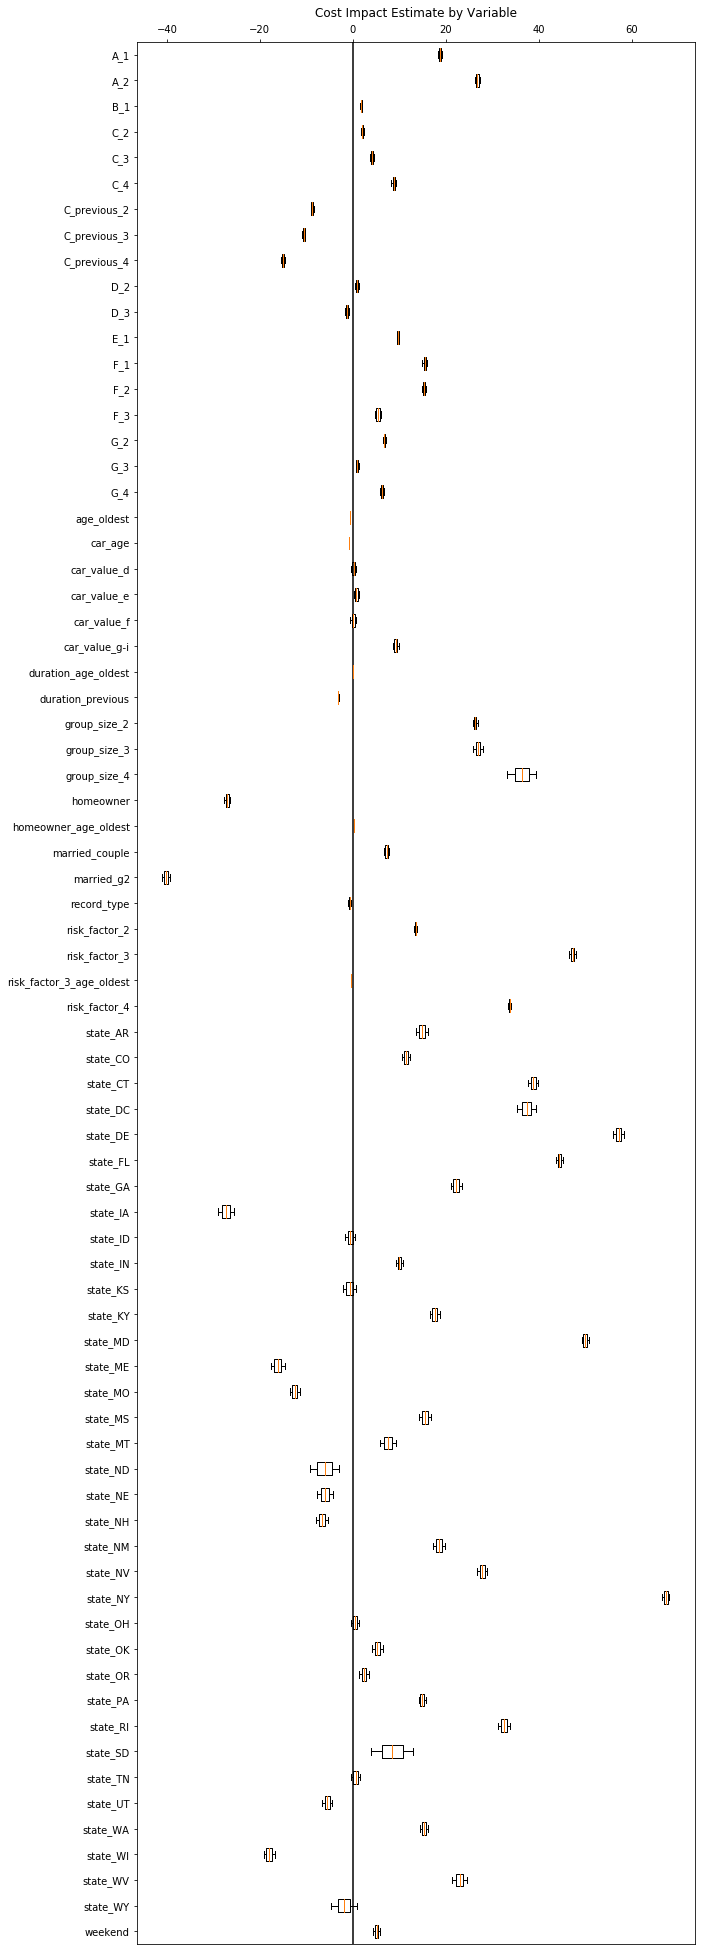

In [93]:
#dir(est2)
paramdf = est2.conf_int()
paramdf['estimate'] = est2.params
paramdf.columns = ['lower_95', 'upper_95', 'coef_estimate']
paramdf.sort_index(inplace=True, ascending=False)
paramdf.drop(['const'], inplace=True)

_ = plt.figure(figsize=(10, 35))
_ = plt.boxplot(paramdf, vert=False)
_ = plt.axes().xaxis.tick_top()
_ = plt.yticks(range(1,75), paramdf.index.values)
_ = plt.title('Cost Impact Estimate by Variable', y=1.01)
_ = plt.axvline(x=0.0, color='black', linestyle='-')

From looking at the above, we can immediately see:

* Variables that are far from zero have a big impact on cost, or **effect size**
* Those with confidence intervals that don't overlap zero are **significant**

Some interesting learnings about car insurance:

* Homewowners tend to pay less for insurance
* Married couples pay more, **but** married couples with only two family members (i.e. no kids) pay much less.
* Cost of insurance varies widely by state.  New York, Maryland, and Delaware show the largest increases, while Midwestern states Iowa, Missouri, and Wisconsin have the largest decreases


## Regression Mechanics and R^2:

Recall **R^2** from earlier. Here are some key points about this metric:

* Explains how much information predictors have regarding changes in the target variable. 
* Ranges from 0.0 (predict the average for every observation) to 1.0 (perfect fit).

## Interactive Visualization with Bokeh:

Bokeh is a Python library that can help connect machine learning models with attractive, interactive, and intuitive visualizations of their results. The demo below shows how a model can be dynamically retrained and displayed based on inputs from the user to integrate the presentation with the rest of the model building process.

Some other ways we could make dynamic ML visualizations:

* Bokeh server
* Tableau with R server
* Others

The visual below shows how well each feature in the dataset predicts the output, and lets the user select different combinations of features to understand the data.

In [97]:
# PCA for plotting and compare predictions to dummy regressor:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor

idx = np.random.choice(X_train.index, 1000, replace=False)

x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

#Set predictions
lm.fit(x_train_sample, y_train_sample)
lm_train_pred_sample = lm.predict(x_train_sample)

regdummy = DummyRegressor(strategy="mean")
regdummy.fit(x_train_sample, y_train_sample)
dummy_y = regdummy.predict(x_train_sample)

scaler = StandardScaler()
X_s = scaler.fit_transform(x_train_sample)

pca = PCA(n_components=1)
pca.fit(X_s)
X_pca = pca.fit_transform(X_s)

m, b = np.polyfit(X_pca[:,0], lm_train_pred_sample, 1)
#plt.plot(X_pca, m*X_pca + b, "-", color="palevioletred")
#plt.axhline(y=regdummy.constant_, linestyle="-", color="limegreen")
#plt.scatter(X_pca[:,0], lm_train_pred_sample)
#plt.ylabel("Predicted Value")
#plt.xlabel("Predictor Variables")
#_ = plt.title("Comparison of Regression with Mean model")

In [95]:
X_names = [nm for nm in X.columns.values]

idx = np.random.choice(X_train.index, 1000, replace=False)
x_train_sample = X_train.ix[idx]
y_train_sample = y_train.ix[idx]

def make_predictions(X, y, X_names):
    """Subset X to selected features, then use to predict y"""
    X = X[X_names]    
    #Fit the model:
    lm.fit(X, y)
    
    return X, y, lm.predict(X)
    
X_train, y_train, lm_train_pred = make_predictions(x_train_sample, y_train_sample, X_names)

regdummy.fit(X_train, y_train)
dummy_y = regdummy.predict(X_train)

def make_plot_arrays(X, predictions):
    """Get first PCA component from X_train for plotting only"""
    # fitting PCA:
    X_s = scaler.fit_transform(X)
    pca = PCA(n_components=1)
    pca.fit(X_s)
    X_pca = pca.fit_transform(X_s)
    # make plot lines:
    m, b = np.polyfit(X_pca[:,0], predictions, 1)
    x_arr = X_pca[:, 0]
    
    # normalize so the scale doesn't change with different sets of features
    x_arr_norm = ( (x_arr - x_arr.min()) / (x_arr.max() - x_arr.min()) )
    
    y_arr = m*X_pca[:, 0] + b
    
    return x_arr_norm, y_arr, m

x_arr, y_arr, slope = make_plot_arrays(X_train, lm_train_pred)

def calc_r2(y_train, preds):
    """ Calculates R^2 based on input data """
    y_mn = np.mean(y_train)
    sst = sum((y_train - y_mn)**2)
    ssr = sum((y_train - preds)**2)
    
    r2 = 1 - (ssr / sst)
    return np.round(r2, 4)

baseline_r2 = calc_r2(y_train, dummy_y)
pred_r2 = calc_r2(y_train, lm_train_pred)

p = figure(title="Regression model vs. baseline", 
           plot_height=600, 
           plot_width=600)

# scatterplot of actual data:
r1 = p.circle(x_arr, y_train, size=10, color="green", alpha=0.5, legend='actual')
# scatterplot of prediction data:
r2 = p.circle(x_arr, lm_train_pred, size=10, color="pink", alpha=0.5, legend='predicted')
# regression model:
r3 = p.line(x_arr, y_arr, color="#2222aa", line_width=3, legend='best fit line')
# baseline dummy model:
p.line(x_arr, dummy_y, color="purple", line_width=2, legend='avg(cost)')

p.xaxis.axis_label = 'Selected Predictors (scaled)'
p.yaxis.axis_label = 'Predicted Cost'

#show(p)


In [96]:
style = {'description_width': '125px'}

m = widgets.SelectMultiple(
    options=sorted(X_names),
    value=sorted(X_names),
    rows=10,
    description='Selected Features:',
    disabled=False,
    layout=Layout(width='50%', height='200px', border='1px dotted blue'),
    style=style
)

def update_regression(features):
    X_selected = list(features)
    
    # update predictions based on selected features:
    X_train, y_train, lm_train_pred = make_predictions(x_train_sample, y_train_sample, X_selected)
    
    regdummy.fit(X_train, y_train)
    dummy_y = regdummy.predict(X_train)
    
    x_arr, y_arr, slope = make_plot_arrays(X_train, lm_train_pred)
    
    # update plots:
    r1.data_source.data['x'] = x_arr
    r1.data_source.data['y'] = y_train
    
    r2.data_source.data['x'] = x_arr
    r2.data_source.data['y'] = lm_train_pred
    
    r3.data_source.data['x'] = x_arr
    r3.data_source.data['y'] = y_arr
    
    pred_r2 = calc_r2(y_train, lm_train_pred)
    baseline_r2 = calc_r2(y_train, dummy_y)
    
    #print('Slope based on selected inputs: {}'.format(slope))
    print('Predicted R^2 on sample data: {}'.format(pred_r2))
    print('Baseline R^2: {}'.format(baseline_r2))
    push_notebook()
    
interact_manual(update_regression, features = m)
show(p, notebook_handle=True)

interactive(children=(SelectMultiple(description='Selected Features:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10…